In [1]:
import os
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import math
import time
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [2]:
#peformance metric functions

#A list of keys for the dictionary returned by p1_metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

metric_keys = ['mse','mae','r2']

def p2_metrics(y_true,y_pred,negation=False):
    if negation:
        sign = -1
    else:
        sign = 1
    return {
        'mse': sign*mean_squared_error(y_true,y_pred),
        'mae': sign*mean_absolute_error(y_true,y_pred),
        'r2': sign*r2_score(y_true,y_pred)}

#This wrapper can be used to return multiple performance metrics during cross-validation
def p2_metrics_scorer(clf,X,y_true):
    y_pred=clf.predict(X)
    return p2_metrics(y_true,y_pred,negation=True)

In [3]:
election_column_names = ["state", "county", "fips", "trump16", "clinton16", "otherpres16", "romney12", "obama12", "otherpres12", "demsen16", "repsen16", "othersen16", 
"demhouse16", "rephouse16", "otherhouse16", "demgov16", "repgov16", "othergov16", "repgov14", "demgov14", "othergov14", "total_population", 
"cvap", "white_pct", "black_pct", "hispanic_pct" ,"nonwhite_pct", "foreignborn_pct", "female_pct", "age29andunder_pct", "age65andolder_pct", 
"median_hh_inc", "clf_unemploy_pct" ,"lesshs_pct", "lesscollege_pct","lesshs_whites_pct", "lesscollege_whites_pct" ,"rural_pct" ,"ruralurban_cc"]


In [4]:
ELECTION_FILE= r"C:\Users\Polymorph\Desktop\College\Year 4\Fall\381\Final Project\election-context-2018.csv"
def load_election_file(election_file = ELECTION_FILE):
    csv_path = os.path.join(election_file, "election-context-2018.csv")
    return pd.read_csv(election_file, names=election_column_names)
election_data = load_election_file()

Dropping the first row that repeats the feature names and resetting the axis

In [5]:
election_data = election_data.drop(labels =0, axis =0)
election_data = election_data.reset_index(drop=True) 
# election_data_temp = election_data
election_data

,state,county,fips,trump16,clinton16,otherpres16,romney12,obama12,otherpres12,demsen16,...,age29andunder_pct,age65andolder_pct,median_hh_inc,clf_unemploy_pct,lesshs_pct,lesscollege_pct,lesshs_whites_pct,lesscollege_whites_pct,rural_pct,ruralurban_cc
0,Alabama,Autauga,1001,18172,5936,865,17379,6363,190,6331,...,40.03705789,13.97845556,53099,5.591657263,12.41704602,75.40722865,10.00211164,74.06560146,42.00216232,2
1,Alabama,Baldwin,1003,72883,18458,3874,66016,18424,898,19145,...,35.47441231,18.71485139,51365,6.286843229,9.972417933,70.45288897,7.842226994,68.40560728,42.27909911,3
2,Alabama,Barbour,1005,5454,4871,144,5550,5912,47,4777,...,37.66438716,16.52889457,33956,12.82473827,26.23592756,87.13221298,19.57975167,81.36474583,67.7896347,6
3,Alabama,Bibb,1007,6738,1874,207,6132,2202,86,2082,...,37.3294347,14.8856991,39776,7.14682672,19.3015873,88,15.02049009,87.47177386,68.35260746,1
4,Alabama,Blount,1009,22859,2156,573,20757,2970,279,2980,...,37.24005268,17.19291557,46212,5.953832753,19.96858533,86.95024321,16.64336837,86.16360993,89.95150204,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,Wyoming,Sweetwater,56037,12154,3231,1745,11428,4774,693,NaN,...,44.15335178,9.417120414,68233,5.07225493,9.314605555,78.62850706,6.238462829,76.60681322,10.91631283,5
3110,Wyoming,Teton,56039,3921,7314,1392,4858,6213,393,NaN,...,35.56999514,11.8375105,75594,2.123446675,4.63356974,46.21158392,1.526877222,41.76950429,46.43091951,7
3111,Wyoming,Uinta,56041,6154,1202,1114,6615,1628,296,NaN,...,43.20585842,10.67821758,53323,6.390754642,10.36122402,81.79308229,8.806312039,81.08085179,43.09593712,7
3112,Wyoming,Washakie,56043,2911,532,371,3014,794,136,NaN,...,34.77427853,19.65034128,46212,7.441860465,12.57710761,78.92392049,10.29973848,75.98068799,35.95452947,7


In [6]:
election_data.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3114 entries, 0 to 3113
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   state                   3114 non-null   object
 1   county                  3114 non-null   object
 2   fips                    3114 non-null   object
 3   trump16                 3114 non-null   object
 4   clinton16               3114 non-null   object
 5   otherpres16             3114 non-null   object
 6   romney12                3114 non-null   object
 7   obama12                 3114 non-null   object
 8   otherpres12             3114 non-null   object
 9   demsen16                1942 non-null   object
 10  repsen16                1942 non-null   object
 11  othersen16              1942 non-null   object
 12  demhouse16              2862 non-null   object
 13  rephouse16              2862 non-null   object
 14  otherhouse16            2862 non-null   object
 15  demg

Dropping columns that have too many missing values

In [7]:
for i in range(len(election_data.columns)-1,0,-1):
    if election_data.isnull().sum()[i] >= (len(election_data)*.30):
        election_data = election_data.drop(election_data.columns[i], axis = 1)

Dropping rows that contain values NA from CVAP

In [8]:
election_data = election_data[election_data['cvap'].notna()]

In [9]:
election_data = election_data.reset_index(drop=True) 

In [10]:
election_data.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3111 entries, 0 to 3110
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   state                   3111 non-null   object
 1   county                  3111 non-null   object
 2   fips                    3111 non-null   object
 3   trump16                 3111 non-null   object
 4   clinton16               3111 non-null   object
 5   otherpres16             3111 non-null   object
 6   romney12                3111 non-null   object
 7   obama12                 3111 non-null   object
 8   otherpres12             3111 non-null   object
 9   demhouse16              2861 non-null   object
 10  rephouse16              2861 non-null   object
 11  otherhouse16            2861 non-null   object
 12  total_population        3111 non-null   object
 13  cvap                    3111 non-null   object
 14  white_pct               3111 non-null   object
 15  blac

Encoding string data into ordinal 

In [11]:
enc = OrdinalEncoder()
columns = ['state', 'county']
enc.fit(election_data[columns])
election_data[columns] = enc.transform(election_data[columns])

Imputation of remaining missing data

In [12]:
# Imputing Missing values to do column arithmatic 
election_data = election_data.replace('NA', np.nan)
# imputing original data 
data_columns = election_data.columns

imp = SimpleImputer(missing_values = np.nan, strategy='median')
imp.fit(election_data)

imputed_election_data = imp.transform(election_data)

imputed_election_data = pd.DataFrame(imputed_election_data, columns = data_columns, index = election_data.index)


Creating columns for turnover rate precentages for each county

In [13]:
turnOver2016 = []
turnOver2012 = []

for i in range(len(imputed_election_data)):
  # Add the values of the three columns
  TurnOver_2016 = (imputed_election_data["trump16"][i] + imputed_election_data["clinton16"][i] + imputed_election_data['otherpres16'][i]) / imputed_election_data['cvap'][i] * 100
  TurnOver_2012 = (imputed_election_data["romney12"][i] + imputed_election_data["obama12"][i] + imputed_election_data['otherpres12'][i]) / imputed_election_data['cvap'][i] * 100
  # Append the result to the array
  turnOver2016.append(TurnOver_2016)
  turnOver2012.append(TurnOver_2012)
    

In [14]:
imputed_election_data

,state,county,fips,trump16,clinton16,otherpres16,romney12,obama12,otherpres12,demhouse16,...,age29andunder_pct,age65andolder_pct,median_hh_inc,clf_unemploy_pct,lesshs_pct,lesscollege_pct,lesshs_whites_pct,lesscollege_whites_pct,rural_pct,ruralurban_cc
0,0.0,78.0,1001.0,18172.0,5936.0,865.0,17379.0,6363.0,190.0,7544.0,...,40.037058,13.978456,53099.0,5.591657,12.417046,75.407229,10.002112,74.065601,42.002162,2.0
1,0.0,85.0,1003.0,72883.0,18458.0,3874.0,66016.0,18424.0,898.0,0.0,...,35.474412,18.714851,51365.0,6.286843,9.972418,70.452889,7.842227,68.405607,42.279099,3.0
2,0.0,96.0,1005.0,5454.0,4871.0,144.0,5550.0,5912.0,47.0,5297.0,...,37.664387,16.528895,33956.0,12.824738,26.235928,87.132213,19.579752,81.364746,67.789635,6.0
3,0.0,144.0,1007.0,6738.0,1874.0,207.0,6132.0,2202.0,86.0,1971.0,...,37.329435,14.885699,39776.0,7.146827,19.301587,88.000000,15.020490,87.471774,68.352607,1.0
4,0.0,159.0,1009.0,22859.0,2156.0,573.0,20757.0,2970.0,279.0,2390.0,...,37.240053,17.192916,46212.0,5.953833,19.968585,86.950243,16.643368,86.163610,89.951502,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,49.0,1576.0,56037.0,12154.0,3231.0,1745.0,11428.0,4774.0,693.0,6536.0,...,44.153352,9.417120,68233.0,5.072255,9.314606,78.628507,6.238463,76.606813,10.916313,5.0
3107,49.0,1601.0,56039.0,3921.0,7314.0,1392.0,4858.0,6213.0,393.0,7417.0,...,35.569995,11.837511,75594.0,2.123447,4.633570,46.211584,1.526877,41.769504,46.430920,7.0
3108,49.0,1654.0,56041.0,6154.0,1202.0,1114.0,6615.0,1628.0,296.0,1826.0,...,43.205858,10.678218,53323.0,6.390755,10.361224,81.793082,8.806312,81.080852,43.095937,7.0
3109,49.0,1710.0,56043.0,2911.0,532.0,371.0,3014.0,794.0,136.0,799.0,...,34.774279,19.650341,46212.0,7.441860,12.577108,78.923920,10.299738,75.980688,35.954529,7.0


Running test to find any extranious rows in our calculations

In [15]:
flagged_counties_2012 = []
for val in range(len(turnOver2012)):
    if turnOver2012[val] > 100:
        flagged_counties_2012.append(val)

In [16]:
for i in range(len(turnOver2012)):
    for j in flagged_counties_2012:
        if i == j:
            print('flagged county ',j, ' turnout range ',turnOver2012[i])

flagged county  271  turnout range  102.22222222222221
flagged county  1776  turnout range  127.8723404255319
flagged county  2361  turnout range  105.50218340611355
flagged county  2642  turnout range  106.66666666666667
flagged county  2647  turnout range  109.34782608695653


In [17]:
flagged_counties_2016 = []
for val in range(len(turnOver2016)):
    if turnOver2016[val] > 100:
        flagged_counties_2016.append(val)

In [18]:
for i in range(len(turnOver2016)):
    for j in flagged_counties_2016:
        if i == j:
            print('flagged county ',j, ' turnout range ',turnOver2016[i])

flagged county  271  turnout range  102.22222222222221
flagged county  1776  turnout range  112.12765957446808
flagged county  2642  turnout range  108.33333333333333
flagged county  2647  turnout range  108.47826086956522


In [19]:
imputed_election_data['turnoutPrecent2016'] = turnOver2016
imputed_election_data['turnoutPrecent2012'] = turnOver2012

Dropping the rows in which contain extrainous values 

In [21]:
for i in range(len(imputed_election_data['turnoutPrecent2012'])-1,0,-1):
    if (imputed_election_data['turnoutPrecent2012'][i]) > 100:
        imputed_election_data = imputed_election_data.drop(i, axis = 0)

In [22]:
imputed_election_data

,state,county,fips,trump16,clinton16,otherpres16,romney12,obama12,otherpres12,demhouse16,...,median_hh_inc,clf_unemploy_pct,lesshs_pct,lesscollege_pct,lesshs_whites_pct,lesscollege_whites_pct,rural_pct,ruralurban_cc,turnoutPrecent2016,turnoutPrecent2012
0,0.0,78.0,1001.0,18172.0,5936.0,865.0,17379.0,6363.0,190.0,7544.0,...,53099.0,5.591657,12.417046,75.407229,10.002112,74.065601,42.002162,2.0,61.373802,58.815434
1,0.0,85.0,1003.0,72883.0,18458.0,3874.0,66016.0,18424.0,898.0,0.0,...,51365.0,6.286843,9.972418,70.452889,7.842227,68.405607,42.279099,3.0,62.736377,56.228504
2,0.0,96.0,1005.0,5454.0,4871.0,144.0,5550.0,5912.0,47.0,5297.0,...,33956.0,12.824738,26.235928,87.132213,19.579752,81.364746,67.789635,6.0,51.381595,56.485890
3,0.0,144.0,1007.0,6738.0,1874.0,207.0,6132.0,2202.0,86.0,1971.0,...,39776.0,7.146827,19.301587,88.000000,15.020490,87.471774,68.352607,1.0,50.136441,47.868107
4,0.0,159.0,1009.0,22859.0,2156.0,573.0,20757.0,2970.0,279.0,2390.0,...,46212.0,5.953833,19.968585,86.950243,16.643368,86.163610,89.951502,1.0,60.306387,56.577893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106,49.0,1576.0,56037.0,12154.0,3231.0,1745.0,11428.0,4774.0,693.0,6536.0,...,68233.0,5.072255,9.314606,78.628507,6.238463,76.606813,10.916313,5.0,56.044495,55.275642
3107,49.0,1601.0,56039.0,3921.0,7314.0,1392.0,4858.0,6213.0,393.0,7417.0,...,75594.0,2.123447,4.633570,46.211584,1.526877,41.769504,46.430920,7.0,77.300275,70.180594
3108,49.0,1654.0,56041.0,6154.0,1202.0,1114.0,6615.0,1628.0,296.0,1826.0,...,53323.0,6.390755,10.361224,81.793082,8.806312,81.080852,43.095937,7.0,59.003831,59.484500
3109,49.0,1710.0,56043.0,2911.0,532.0,371.0,3014.0,794.0,136.0,799.0,...,46212.0,7.441860,12.577108,78.923920,10.299738,75.980688,35.954529,7.0,62.167889,64.286879


Splitting data intro training validaiton and test sets 

In [24]:
from sklearn.model_selection import ShuffleSplit
election_split = ShuffleSplit(n_splits = 1 ,test_size = 0.2, random_state=23730704)
for train_index, test_index in election_split.split(imputed_election_data):
    election_TrainAndValidation = imputed_election_data.iloc[train_index]
    election_test_set = imputed_election_data.iloc[test_index]
    
election_split2 = ShuffleSplit(n_splits = 1,  test_size = 0.25, random_state = 23730704)
for train_index, test_index in election_split2.split(election_TrainAndValidation):
    election_train_set = election_TrainAndValidation.iloc[train_index]
    election_validation_set = election_TrainAndValidation.iloc[test_index]

In [25]:
data_columns = imputed_election_data.columns
imp.fit(imputed_election_data)
# imputing split data
imputed_election_TrainAndValidation = imp.transform(election_TrainAndValidation)
imputed_election_train_set = imp.transform(election_train_set)
imputed_election_validation_set = imp.transform(election_validation_set)
imputed_election_test_set = imp.transform(election_test_set)

# dataframing split data
imputed_election_TrainAndValidation = pd.DataFrame(imputed_election_TrainAndValidation, columns = data_columns, index = election_TrainAndValidation.index)
imputed_election_train_set = pd.DataFrame(imputed_election_train_set, columns = data_columns, index = election_train_set.index)
imputed_election_validation_set = pd.DataFrame(imputed_election_validation_set, columns = data_columns, index = election_validation_set.index)
imputed_election_test_set = pd.DataFrame(imputed_election_test_set, columns = data_columns, index = election_test_set.index)



Creating figures to establish relattionship between key features

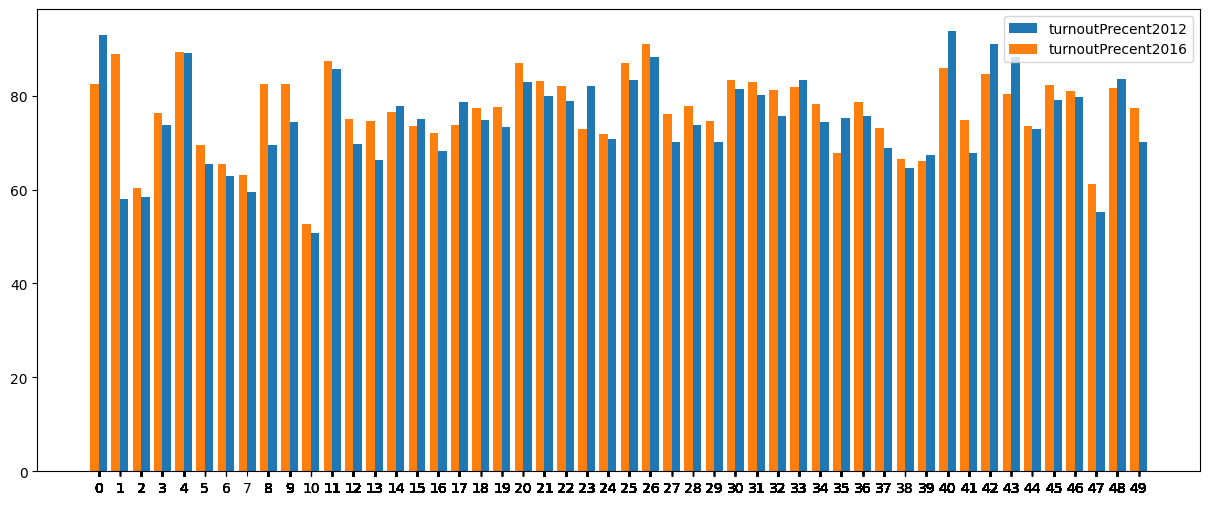

In [26]:
plt.figure(figsize=(15,6))

labels = imputed_election_data['state']
y1 = imputed_election_data['turnoutPrecent2012']
y2 = imputed_election_data['turnoutPrecent2016']

plt.xticks(imputed_election_data['state'])
plt.bar(labels - (-0.2), y1, 0.4, label = 'turnoutPrecent2012')
plt.bar(labels - 0.2, y2, 0.4, label = 'turnoutPrecent2016')
plt.legend()
plt.show()

Showing relationship between Counties and States 

In [27]:
temparray1 = []
temparray2 = []
for key, value in imputed_election_data['state'].value_counts().to_dict().items():
    temparray1.append(key)
    temparray2.append(value)

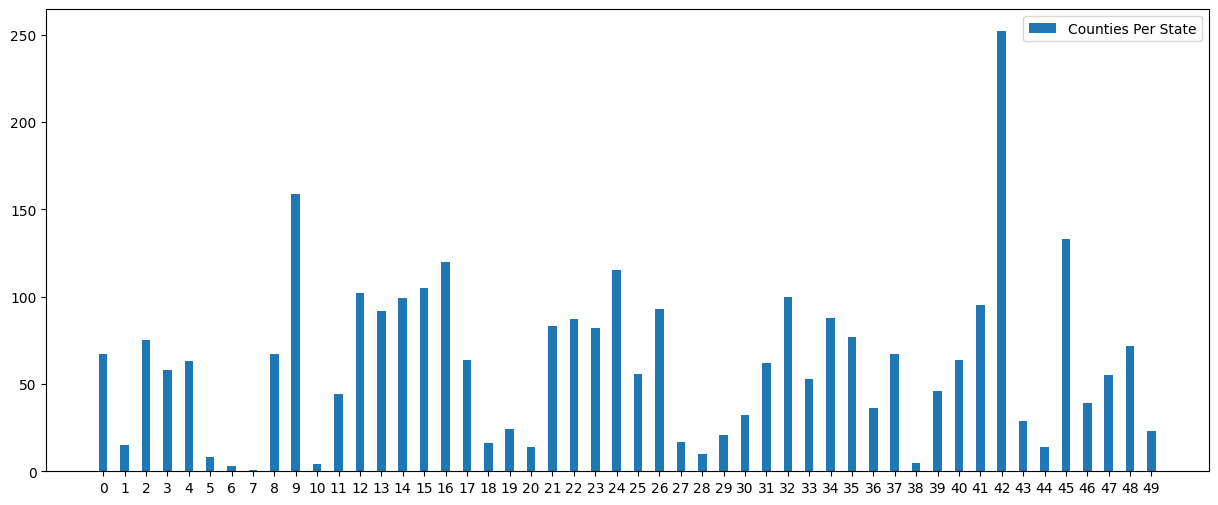

In [28]:
plt.figure(figsize=(15,6))

plt.xticks(temparray1)
plt.bar(temparray1, temparray2, 0.4, label = 'Counties Per State')
plt.legend()
plt.show()

In [29]:
# Crossvalidation using Training and Validation 
cv_x = imputed_election_TrainAndValidation.drop('turnoutPrecent2016', axis = 1)
cv_y = imputed_election_TrainAndValidation['turnoutPrecent2016']

kf = KFold(n_splits = 5, shuffle = True, random_state = 23730704)
for train_index, test_index in kf.split(cv_x, cv_y):
    X_train_kfold, X_test_kfold = cv_x.iloc[train_index], cv_x.iloc[test_index]
    y_train_kfold, y_test_kfold = cv_y.iloc[train_index], cv_y.iloc[test_index]

In [30]:
X_train = imputed_election_train_set.drop('turnoutPrecent2016', axis = 1)
y_train = imputed_election_train_set['turnoutPrecent2016']

X_validation = imputed_election_validation_set.drop('turnoutPrecent2016', axis = 1)
y_validation = imputed_election_validation_set['turnoutPrecent2016']

X_test = imputed_election_test_set.drop('turnoutPrecent2016', axis = 1)
y_test = imputed_election_test_set['turnoutPrecent2016']

Linear Regression

In [31]:
reg = LinearRegression().fit(X_train, y_train)

In [32]:
pred_test = reg.predict(X_test)

In [33]:
Lin_Reg = p2_metrics_scorer(reg,X_train, y_train)
Lin_Reg

{'mse': -6.625020116573754,
 'mae': -1.7623719735710308,
 'r2': -0.9218344514845682}

In [34]:
len(pred_test)

622

NOTE: DELAWARE STATE # 7 HAS 3 COUNTIES
RHODE ISLAND STATE # 38 HAS 5 COUNTIES 

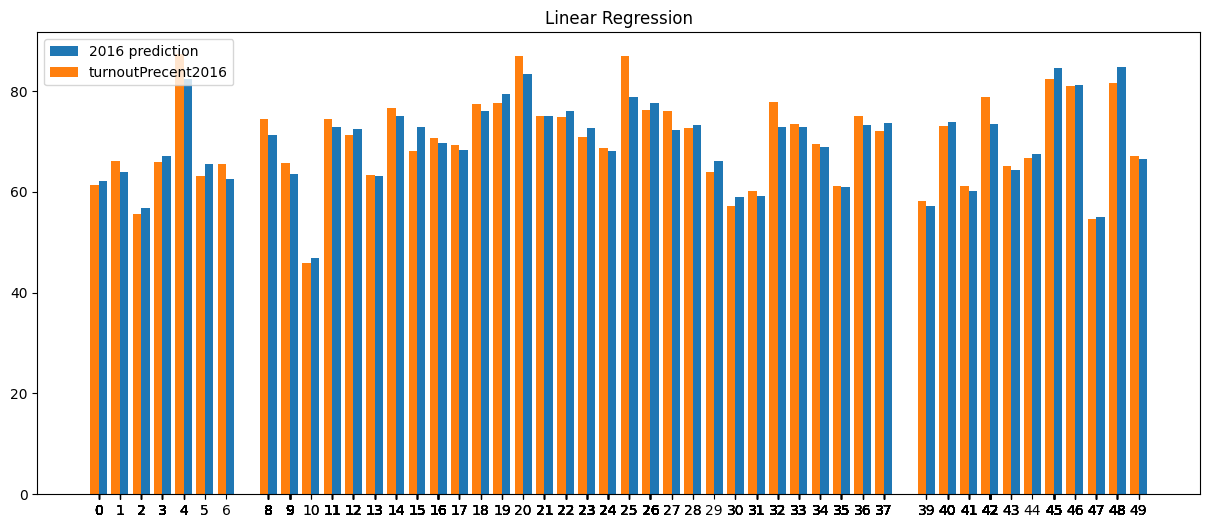

In [35]:
plt.figure(figsize=(15,6))

labels = imputed_election_test_set['state']
y2 = imputed_election_test_set['turnoutPrecent2016']

plt.xticks(imputed_election_test_set['state'])
plt.bar(labels - (-0.2), pred_test, 0.4, label = '2016 prediction')
plt.bar(labels - 0.2, y2, 0.4, label = 'turnoutPrecent2016')
plt.title("Linear Regression")
plt.legend()
plt.show()

Random Forest Regressor

In [36]:
random_grid = {'bootstrap': [True, False],
               'max_depth':[None,  math.ceil(math.log(len(X_train)-1,2))],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf_model_ht = RandomForestRegressor()

start_rf = time.time()
RF_hyper_tuning_random = RandomizedSearchCV(rf_model_ht, random_grid, n_iter= 10,cv=kf, n_jobs= -1, refit='r2', return_train_score=False, scoring=p2_metrics_scorer, random_state=23730704, verbose=10)
RF_hyper_tuning_random.fit(cv_x, cv_y)
end_rf = time.time()
print(end_rf - start_rf)
RF_hyper_tuning_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.


298.5853774547577


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 11,
 'bootstrap': False}

In [37]:
RF_hyper_tuning_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 11,
 'bootstrap': False}

In [38]:
RF_clf = RF_hyper_tuning_random.best_estimator_
RF_model = RF_clf.predict(X_test)
p2_metrics(y_test, RF_model)


{'mse': 12.637038154267225, 'mae': 2.6653726736266914, 'r2': 0.855039510481014}

In [39]:
RF_clf

RandomForestRegressor(bootstrap=False, max_depth=11, max_features='auto',
                      n_estimators=200)

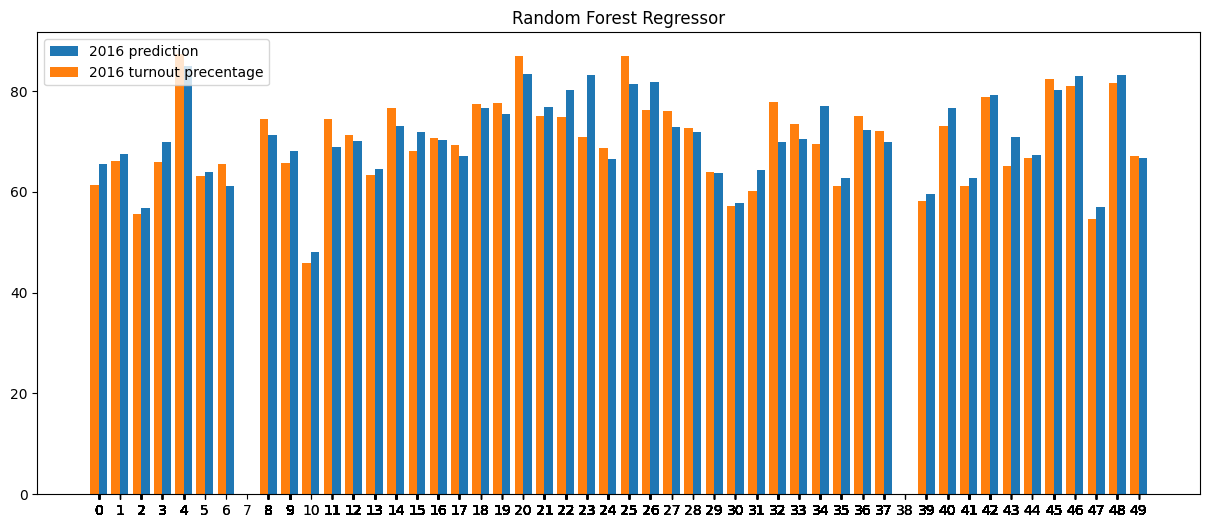

In [40]:
plt.figure(figsize=(15,6))

labels = imputed_election_test_set['state']
y2 = imputed_election_test_set['turnoutPrecent2016']

plt.xticks(X_train['state'])
plt.bar(labels + 0.2, RF_model, 0.4, label = '2016 prediction')
plt.bar(labels - 0.2, y2, 0.4 , label = '2016 turnout precentage')
plt.title("Random Forest Regressor")
plt.legend()
plt.show()


Using SHAP explanations to show relationships between our features for each model

In [46]:
SHAP for linear regression model

SyntaxError: invalid syntax (1472493058.py, line 1)

In [41]:
explainer = shap.Explainer(RF_clf.predict, X_test)
shap_values = explainer(X_test)


Permutation explainer: 623it [11:48,  1.15s/it]                                                                        


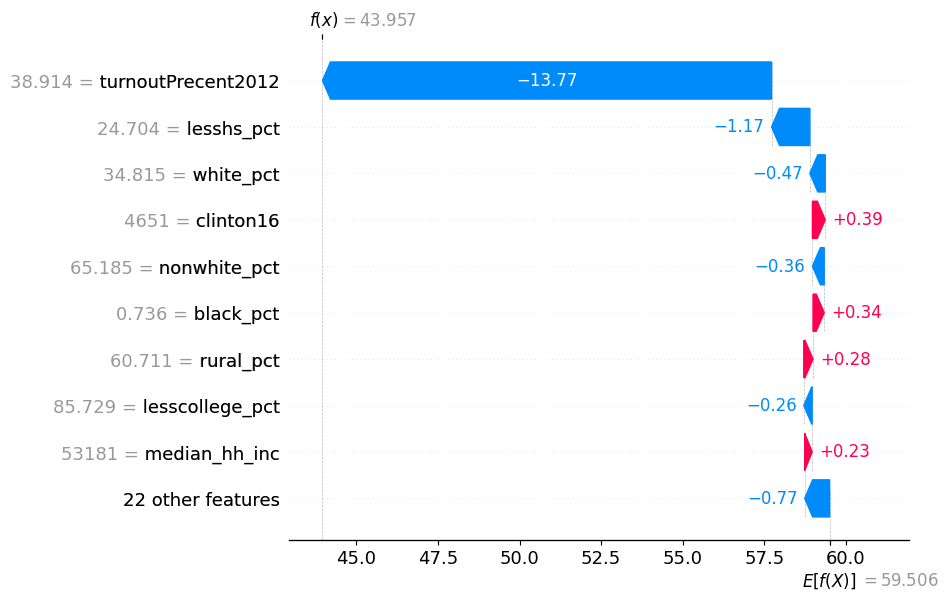

In [42]:
shap.plots.waterfall(shap_values[0])


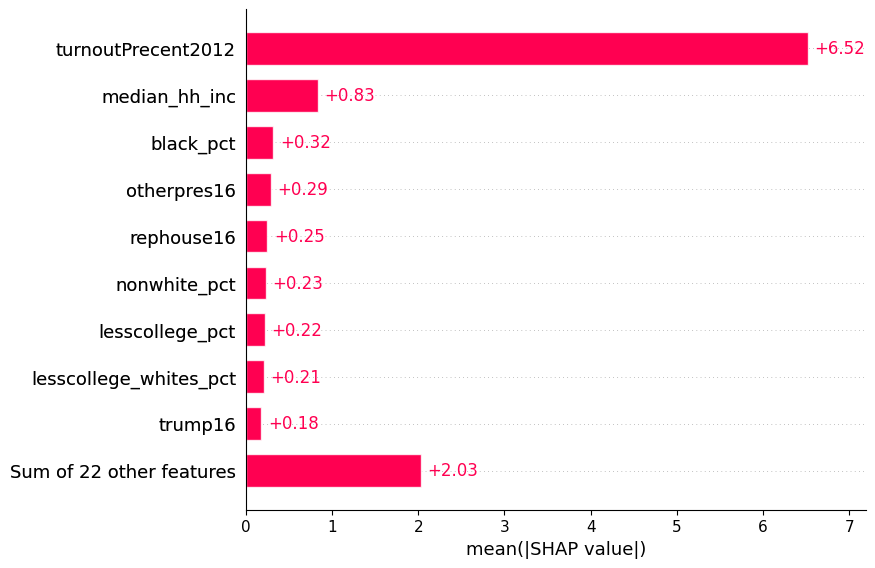

In [43]:
shap.plots.bar(shap_values)

SHAP for Random Forest Regressor

In [44]:
explainer_reg = shap.Explainer(reg.predict, X_test)
shap_values_reg = explainer(X_test)


Permutation explainer: 623it [11:32,  1.13s/it]                                                                        


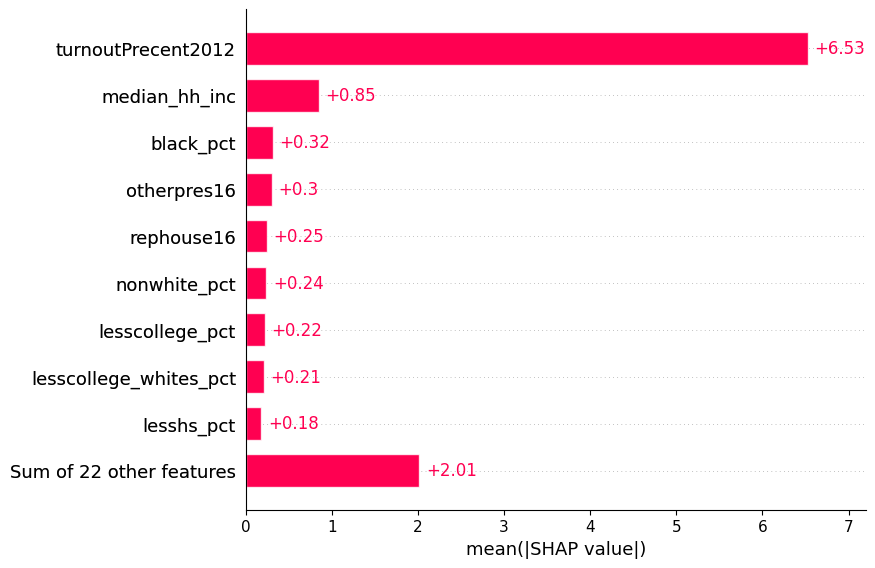

In [45]:
shap.plots.bar(shap_values_reg)